## **Importing libraries**

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import cv2
import os

C:\Users\dell\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## **Removing annotation file with size zero**

In [2]:
annotation_dirs = ["Bear_Datasets/train/labels"]

print(len(os.listdir(annotation_dirs[0])))

for annotation_dir in annotation_dirs:
  annotations = os.listdir(annotation_dir)
  for annotation in annotations:
    annotation_file = os.path.join(annotation_dir, annotation)
    if os.path.getsize(annotation_file) == 0:
      os.remove(annotation_file)

print(len(os.listdir(annotation_dirs[0])))

1521
1521


## **Create customdataset class**

In [3]:
# Step 1: Custom Dataset Class
class CustomDataset():
    def __init__(self, image_dir, annotations, annotations_dir, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        
        # get annotation file name
        annotation = self.annotations[idx]
        # get image path     .txt
        img_path = os.path.join(self.image_dir, annotation[:-4]+'.jpg')
        # load image
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image {img_path} not found.")
        # convert image channels
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get image dimensions
        height, width, _ = image.shape

        # Parse the annotation file
        annotation_file = os.path.join(self.annotations_dir, annotation)
        boxes = []
        labels = []
        # open annotation file
        with open(annotation_file, "r") as f:
            for line in f:
                
                # split data
                data = line.strip().split()
                class_index = int(data[0])  # Class index
                x_center = float(data[1]) * width
                y_center = float(data[2]) * height
                box_width = float(data[3]) * width
                box_height = float(data[4]) * height

                # Convert to absolute coordinates [xmin, ymin, xmax, ymax]
                xmin = x_center - box_width / 2
                ymin = y_center - box_height / 2
                xmax = x_center + box_width / 2
                ymax = y_center + box_height / 2

                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(int(1))

        # Convert to PyTorch tensors
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        # Create target dictionary
        target = {"boxes": boxes, "labels": labels}
        return image, target


## **Load Pretrained Model and Modify for Custom Classes**

In [4]:
num_classes = 2  # Number of classes (1 background + 1 custom classes)

## get the pretrained backbone model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="COCO_V1")

print(model)

# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(
    in_features, num_classes)


for param in model.backbone.parameters():
    param.requires_grad = True


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## **Creating the Dataloader**

In [6]:
# Step 4: Dataset and DataLoader
train_image_dir = "Bear_Datasets/train/images"
train_annotation_dir = "Bear_Datasets/train/labels"
train_annotations = os.listdir(train_annotation_dir)

train_dataset = CustomDataset(train_image_dir, train_annotations, train_annotation_dir, transform=transforms.ToTensor())

train_data_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [7]:
print(len(train_data_loader))

381


## **Setting LR OPTIM**

In [8]:
# Step 5: Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
num_epochs = 10


# Epoch 1, LR: 0.001000
# Epoch 2, LR: 0.001000
# Epoch 3, LR: 0.001000
# Epoch 4, LR: 0.001 * 0.1 ==   0.000100
# Epoch 5, LR: 0.000100
# Epoch 6, LR: 0.000100
# Epoch 7, LR: 0.0001 * 0.1 == 0.000010

## **Checking Dataloader**

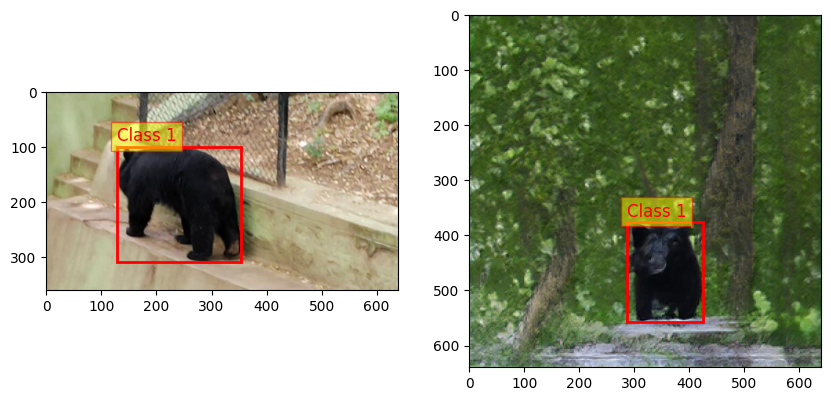

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

# Get a batch of images and targets from the data loader
data_loader_iter = iter(train_data_loader)
images, targets = next(data_loader_iter)

# Plot the images with bounding boxes
for idx in range(2):
    image = images[idx].permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C) for visualization
    target = targets[idx]
    boxes = target["boxes"].numpy()
    labels = target["labels"].numpy()

    ax[idx].imshow(image)

    # Add bounding boxes to the image
    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = box
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle(
            (xmin, ymin),
            width,
            height,
            linewidth=2,
            edgecolor="red",
            facecolor="none",
        )
        ax[idx].add_patch(rect)
        ax[idx].text(
            xmin,
            ymin - 10,
            f"Class {label}",
            color="red",
            fontsize=12,
            bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
        )

# Display the image with bounding boxes
plt.show()

In [11]:
# Step 6: Training Loop

train_loss = []
val_loss = []

for epoch in range(num_epochs):

    print(f'Starting the trainig of Epoch_{epoch+1}.....')
    print('Training...')

    model.train()
    train_running_loss = 0

    print(f'Epoch {epoch+1}/{num_epochs} training')


    for images, targets in train_data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        # loss_classifier → Measures how well the model classifies objects into correct categories.
        # loss_box_reg → Evaluates how accurately the predicted bounding boxes match the ground truth.
        # loss_objectness → Checks how confident the model is in detecting objects versus background.
        # loss_rpn_box_reg → Assesses how well the Region Proposal Network (RPN) refines anchor boxes to better fit objects.
        
        # Backward pass
        optimizer.zero_grad() ## converting gradient value to zero for per batch
        losses.backward() ## compute the gradient
        optimizer.step() ## update the weights

        train_running_loss += losses.item()

    scheduler.step()
    train_loss.append(train_running_loss)
    print(f"Train_Loss: {train_running_loss/len(train_dataset):.4f}")
    print('\n')

Starting the trainig of Epoch_1.....
Training...
Epoch 1/10 training


RuntimeError: CUDA out of memory. Tried to allocate 264.00 MiB (GPU 0; 2.00 GiB total capacity; 4.48 GiB already allocated; 0 bytes free; 4.66 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# Step 7: Save Trained Model
torch.save(model.state_dict(), "faster_rcnn_custom.pth")

{'boxes': tensor([[139.4169,  75.9746, 403.6157, 393.5614],
        [409.3229, 284.5507, 558.4352, 396.2554],
        [265.3229, 261.3100, 382.6588, 380.3168],
        [160.9485, 201.4016, 357.0433, 377.7274],
        [152.7533,  80.0734, 382.9597, 259.1056]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9994, 0.9992, 0.8286, 0.3480, 0.1667], device='cuda:0')}
{'boxes': tensor([[  5.9014,   1.4165, 208.9532, 280.3718],
        [220.6841, 140.7203, 510.0685, 350.5724],
        [107.5716,  60.8760, 499.8234, 342.9225],
        [ 68.5646,   6.5729, 339.1415, 296.8442],
        [144.4345,  29.7595, 327.4171, 233.4191]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9990, 0.9990, 0.8656, 0.8429, 0.0889], device='cuda:0')}


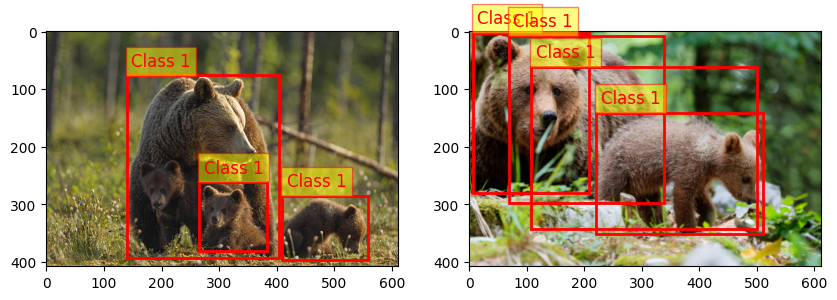

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import random
import os
import torch
import torchvision
from torchvision.transforms import transforms


# Step 1: Recreate the model architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Step 3: Load Pretrained Model and Modify for Custom Classes
num_classes = 2  # Number of classes (2 custom classes + 1 background)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Replace the classification head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


model.load_state_dict(torch.load("faster_rcnn_custom.pth"))
# Assuming `model` and `test_data_loader` are already defined
model.eval()  # Set the model to evaluation mode
model.to(device)  # Ensure the model is on the correct device

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax = ax.ravel()

transform = transforms.ToTensor()

test_dir = "Bear_Datasets/test"
test_list_file = os.listdir(test_dir)

for idx in range(2):
    # Prepare the image
    image = Image.open(os.path.join(test_dir,random.choice(test_list_file)))
    image = transform(image)
    image_tensor = image.unsqueeze(0).to(device)  # Add a batch dimension

    # Get predictions
    with torch.no_grad():
        prediction = model(image_tensor)[0]  # Get the first image's predictions
    
    print(prediction)

    # Convert image to numpy for visualization
    image_np = image.cpu().permute(1, 2, 0).numpy()  # Convert (C, H, W) -> (H, W, C)

    # Extract predictions
    boxes = prediction["boxes"].cpu().numpy()
    labels = prediction["labels"].cpu().numpy()
    scores = prediction["scores"].cpu().numpy()

    ax[idx].imshow(image_np)

    # Add bounding boxes to the image
    for box, label, score in zip(boxes, labels, scores):
        if score >= 0.8:
            xmin, ymin, xmax, ymax = box
            width, height = xmax - xmin, ymax - ymin
            rect = patches.Rectangle(
                (xmin, ymin),
                width,
                height,
                linewidth=2,
                edgecolor="red",
                facecolor="none",
            )
            ax[idx].add_patch(rect)
            ax[idx].text(
                xmin + 8,
                ymin - 16,
                f"Class {label}",
                color="red",
                fontsize=12,
                bbox=dict(facecolor="yellow", alpha=0.5, edgecolor="red"),
            )

# Display the image with bounding boxes
plt.show()